<a href="https://colab.research.google.com/github/hissain/mlworks/blob/main/codes/Model_Quantization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Load Data and libraries
import os
import cv2
import time
import torch
import numpy as np
import torchvision
from PIL import Image
import torch.nn as nn
import matplotlib.pyplot as plt
from torchvision import transforms
from torchvision import datasets, models, transforms

device = "cpu"

print(device)
transform = transforms.Compose([
    transforms.Resize(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

batch_size = 8

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

def print_model_size(mdl):
    torch.save(mdl.state_dict(), "tmp.pt")
    print("%.2f MB" %(os.path.getsize("tmp.pt")/1e6))
    os.remove('tmp.pt')

cpu


100%|██████████| 170498071/170498071 [00:02<00:00, 78676341.80it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


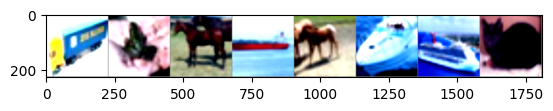

In [ ]:
#@title Show Images
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# print labels

In [ ]:
#@title Define Model
from torch.nn import init
class mAlexNet(nn.Module):
    def __init__(self, num_classes=2):
        super().__init__()
        self.input_channel = 3
        self.num_output = num_classes
        #self.quant = torch.ao.quantization.QuantStub()
        self.layer1 = nn.Sequential(
            nn.Conv2d(in_channels=self.input_channel, out_channels= 16, kernel_size= 11, stride= 4),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        init.xavier_uniform_(self.layer1[0].weight,gain= nn.init.calculate_gain('conv2d'))

        self.layer2 = nn.Sequential(
            nn.Conv2d(in_channels= 16, out_channels= 20, kernel_size= 5, stride= 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        init.xavier_uniform_(self.layer2[0].weight,gain= nn.init.calculate_gain('conv2d'))

        self.layer3 = nn.Sequential(
            nn.Conv2d(in_channels= 20, out_channels= 30, kernel_size= 3, stride= 1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        init.xavier_uniform_(self.layer3[0].weight,gain= nn.init.calculate_gain('conv2d'))
        #self.dequant = torch.ao.quantization.DeQuantStub()

        self.layer4 = nn.Sequential(
            nn.Linear(30*3*3, out_features=48),
            nn.ReLU(inplace=True)
        )
        init.kaiming_normal_(self.layer4[0].weight, mode='fan_in', nonlinearity='relu')

        self.layer5 = nn.Sequential(
            nn.Linear(in_features=48, out_features=self.num_output)
        )
        init.kaiming_normal_(self.layer5[0].weight, mode='fan_in', nonlinearity='relu')


    def forward(self, x):
        #x = self.quant(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.dequant(x)

        # Squeezes or flattens the image, but keeps the batch dimension
        x = x.reshape(x.size(0), -1)
        x = self.layer4(x)
        logits= self.layer5(x)
        return logits

model = mAlexNet(num_classes= 10).to(device)

In [ ]:
len(trainloader)

6250

In [ ]:
import torch.optim as optim

def train_model(model):
  criterion =  nn.CrossEntropyLoss()
  optimizer = optim.SGD(model.parameters(), lr=0.001, momentum = 0.9)

  for epoch in range(2):
    running_loss =0.0

    for i, data in enumerate(trainloader,0):

      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()
      outputs = model(inputs)
      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # print statistics
      running_loss += loss.item()
      if i % 1000 == 999:
        print(f'[Ep: {epoch + 1}, Step: {i + 1:5d}] loss: {running_loss / 2000:.3f}')
        running_loss = 0.0

  return model

model = train_model(model)

[Ep: 1, Step:  1000] loss: 1.003
[Ep: 1, Step:  2000] loss: 0.884
[Ep: 1, Step:  3000] loss: 0.824
[Ep: 1, Step:  4000] loss: 0.799
[Ep: 1, Step:  5000] loss: 0.780
[Ep: 1, Step:  6000] loss: 0.767
[Ep: 2, Step:  1000] loss: 0.741
[Ep: 2, Step:  2000] loss: 0.735
[Ep: 2, Step:  3000] loss: 0.729
[Ep: 2, Step:  4000] loss: 0.714
[Ep: 2, Step:  5000] loss: 0.707
[Ep: 2, Step:  6000] loss: 0.694


In [ ]:
PATH = './float_model.pth'
torch.save(model.state_dict(), PATH)

#Quantization Methods
1. Dynamic qunatization — makes the weights integer (after training)

2. Static quantization — makes the weights and activations integers (after training)

3. Quantization aware training — training the model from the begining with integer precission

In whichever way we proceed, the main motivation behind quantization of deep neural networks is to improve the inference speed as its needless to say that inference and training of NNs is computationally quite expensive. With the advent of Large Language Models, the number of parameters in these models are only increasing meaning that the memory footprint is only getting higher and higher. With the speed at which these neural networks are evolving, there is increasing demand to run these neural networks on our laptops or mobile phones and even tiny devices like watches. None of this is possible without quantization.Before diving into quantization, lets not forget that trained Neural Networks are mere floating numbers stored in computer’s memory.

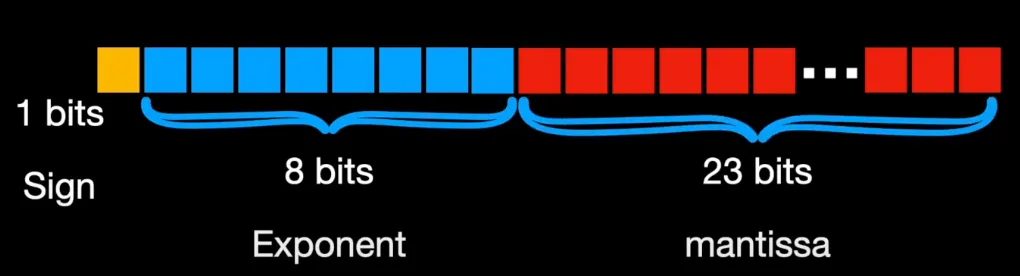

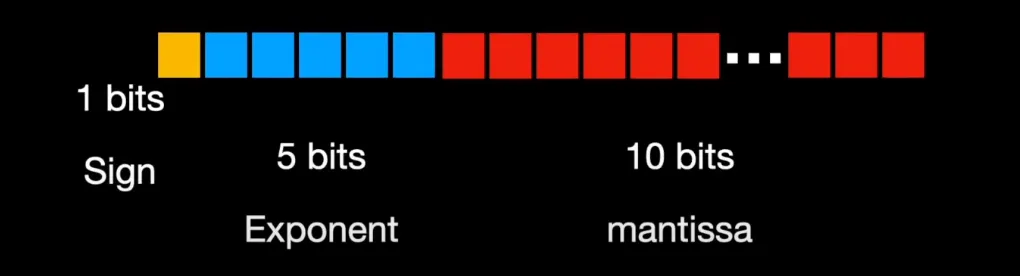

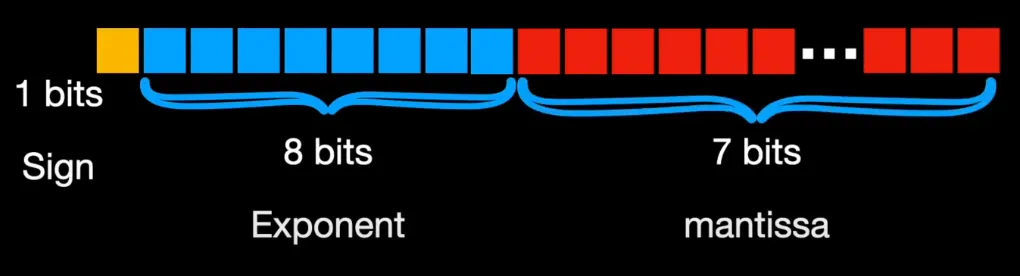

##Symmetric and Asymmetric Quantization


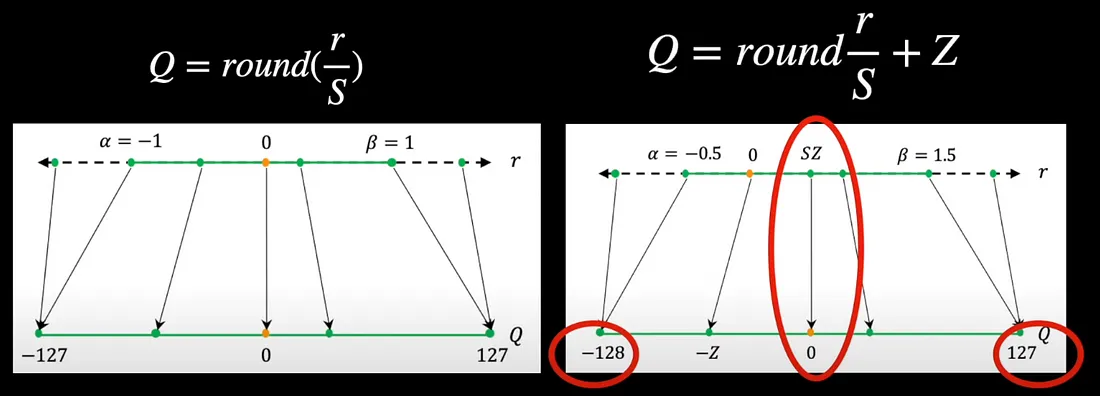

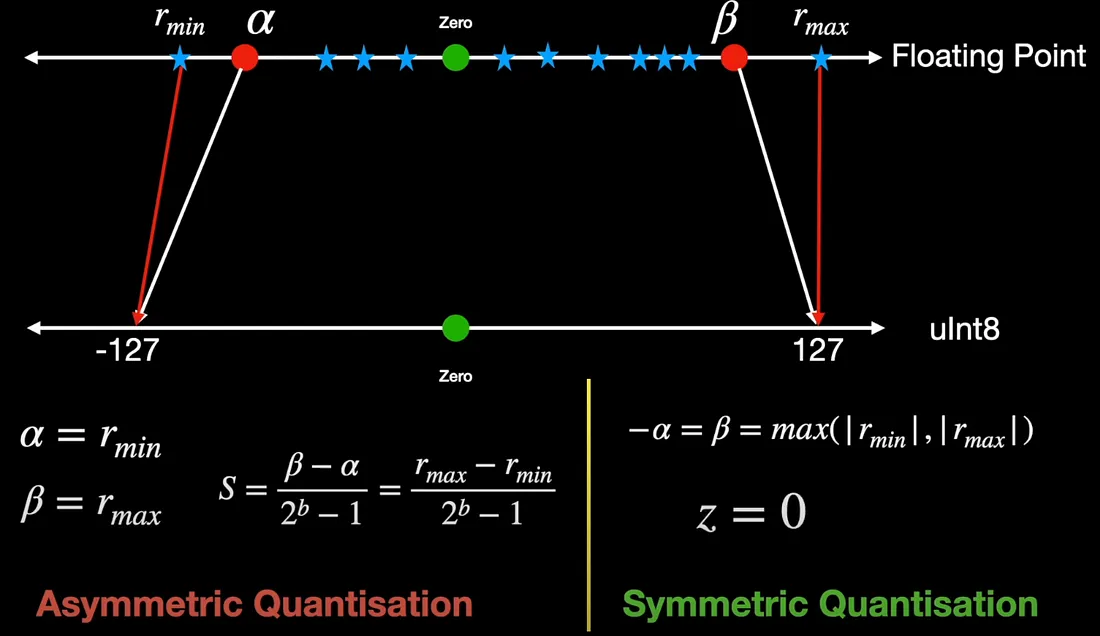

## Post training dynamic/weight_only quantization

In [ ]:

import torch
from torch.ao.quantization import (
  get_default_qconfig_mapping,
  get_default_qat_qconfig_mapping,
  QConfigMapping,
)
import torch.ao.quantization.quantize_fx as quantize_fx
import copy

# Load float model
model_fp = mAlexNet(num_classes= 10).to(device)
model_fp.load_state_dict(torch.load("./float_model.pth", map_location=device))

# Copy model to qunatize
model_to_quantize = copy.deepcopy(model_fp).to(device)
model_to_quantize.eval()
qconfig_mapping = QConfigMapping().set_global(torch.ao.quantization.default_dynamic_qconfig)
# a tuple of one or more example inputs are needed to trace the model
example_inputs = next(iter(trainloader))[0]

# prepare
model_prepared = quantize_fx.prepare_fx(model_to_quantize, qconfig_mapping, example_inputs)
# no calibration needed when we only have dynamic/weight_only quantization
# quantize
model_quantized_dynamic = quantize_fx.convert_fx(model_prepared)


In [ ]:
print_model_size(model)
print_model_size(model_quantized_dynamic)

0.13 MB
0.10 MB


## Post training static quantization

In [ ]:
model_to_quantize = copy.deepcopy(model_fp)
qconfig_mapping = get_default_qconfig_mapping("qnnpack") #For mobile device
model_to_quantize.eval()
# prepare
model_prepared = quantize_fx.prepare_fx(model_to_quantize, qconfig_mapping, example_inputs)
# calibrate
with torch.no_grad():
    for i in range(20):
        batch = next(iter(trainloader))[0]
        output = model_prepared(batch.to(device))



In [ ]:
model_prepared

GraphModule(
  (activation_post_process_0): HistogramObserver(min_val=-2.1179039478302, max_val=2.640000104904175)
  (layer1): Module(
    (0): ConvReLU2d(
      (0): Conv2d(3, 16, kernel_size=(11, 11), stride=(4, 4))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (activation_post_process_1): HistogramObserver(min_val=0.0, max_val=16.079608917236328)
  (activation_post_process_2): HistogramObserver(min_val=0.0, max_val=16.079608917236328)
  (layer2): Module(
    (0): ConvReLU2d(
      (0): Conv2d(16, 20, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU(inplace=True)
    )
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (activation_post_process_3): HistogramObserver(min_val=0.0, max_val=22.809263229370117)
  (activation_post_process_4): HistogramObserver(min_val=0.0, max_val=22.809263229370117)
  (layer3): Module(
    (0): ConvReLU2d(
      (0): Conv2d(20, 30, kerne

In [ ]:
# quantize
model_quantized_static = quantize_fx.convert_fx(model_prepared)

In [ ]:
model_quantized_static

GraphModule(
  (layer1): Module(
    (0): QuantizedConvReLU2d(3, 16, kernel_size=(11, 11), stride=(4, 4), scale=0.05474407225847244, zero_point=0)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Module(
    (0): QuantizedConvReLU2d(16, 20, kernel_size=(5, 5), stride=(1, 1), scale=0.07276392728090286, zero_point=0)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Module(
    (0): QuantizedConvReLU2d(20, 30, kernel_size=(3, 3), stride=(1, 1), scale=0.05260739102959633, zero_point=0)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Module(
    (0): QuantizedLinearReLU(in_features=270, out_features=48, scale=0.06391118466854095, zero_point=0, qscheme=torch.per_tensor_affine)
  )
  (layer5): Module(
    (0): QuantizedLinear(in_features=48, out_features=10, scale=0.06699740886688232, zero_point=120, qscheme=torch.per_tensor_affine)
  )
)

In [ ]:
print_model_size(model)
print_model_size(model_quantized_dynamic)
print_model_size(model_quantized_static)

0.13 MB
0.10 MB
0.04 MB


## Quantization aware training for static quantization

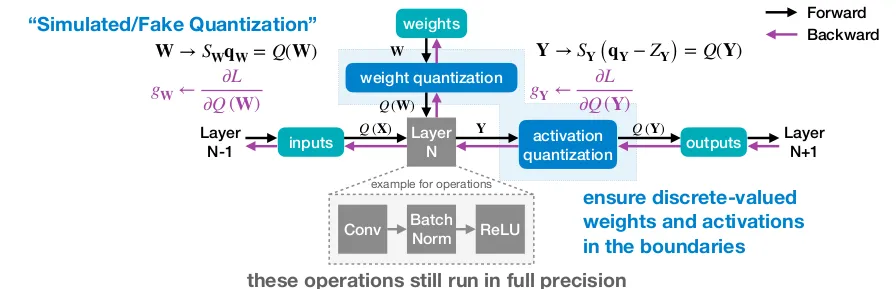

In [ ]:
model_to_quantize = mAlexNet(num_classes= 10).to(device)
#model_to_quantize = copy.deepcopy(model)
qconfig_mapping = get_default_qat_qconfig_mapping("qnnpack")
model_to_quantize.train()
# prepare
model_prepared = quantize_fx.prepare_qat_fx(model_to_quantize, qconfig_mapping, example_inputs)

# training loop
model_trained_prepared = train_model(model_prepared)

# quantize
model_quantized_trained = quantize_fx.convert_fx(model_trained_prepared)


[Ep: 1, Step:  1000] loss: 1.007
[Ep: 1, Step:  2000] loss: 0.884
[Ep: 1, Step:  3000] loss: 0.841
[Ep: 1, Step:  4000] loss: 0.811
[Ep: 1, Step:  5000] loss: 0.793
[Ep: 1, Step:  6000] loss: 0.766
[Ep: 2, Step:  1000] loss: 0.746
[Ep: 2, Step:  2000] loss: 0.735
[Ep: 2, Step:  3000] loss: 0.711
[Ep: 2, Step:  4000] loss: 0.712
[Ep: 2, Step:  5000] loss: 0.709
[Ep: 2, Step:  6000] loss: 0.703


In [ ]:
model_quantized_trained

GraphModule(
  (layer1): Module(
    (0): QuantizedConvReLU2d(3, 16, kernel_size=(11, 11), stride=(4, 4), scale=0.06306459754705429, zero_point=0)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Module(
    (0): QuantizedConvReLU2d(16, 20, kernel_size=(5, 5), stride=(1, 1), scale=0.07485044747591019, zero_point=0)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Module(
    (0): QuantizedConvReLU2d(20, 30, kernel_size=(3, 3), stride=(1, 1), scale=0.044375091791152954, zero_point=0)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer4): Module(
    (0): QuantizedLinearReLU(in_features=270, out_features=48, scale=0.0406007319688797, zero_point=0, qscheme=torch.per_tensor_affine)
  )
  (layer5): Module(
    (0): QuantizedLinear(in_features=48, out_features=10, scale=0.04446762055158615, zero_point=151, qscheme=torch.per_tensor_affine)
  )
)

In [ ]:
print("Regular floating point model: " )
print_model_size( model_fp)
print("Weights only qunatization: ")
print_model_size( model_quantized_dynamic)
print("Weights/Activations only qunatization: ")
print_model_size(model_quantized_static)
print("Qunatization aware trained: ")
print_model_size(model_quantized_trained)

Regular floating point model: 
0.13 MB
Weights only qunatization: 
0.10 MB
Weights/Activations only qunatization: 
0.04 MB
Qunatization aware trained: 
0.04 MB


In [ ]:
def get_accuracy(model):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images, labels
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

      return 100 * correct / total

fp_model_acc = get_accuracy(model)
dy_model_acc = get_accuracy(model_quantized_dynamic)
static_model_acc = get_accuracy(model_quantized_static)
q_trained_model_acc = get_accuracy(model_quantized_trained)


print("Acc on fp_model:" ,fp_model_acc)
print("Acc weigths only quantization:", dy_model_acc)
print("Acc weigths/activations quantization" ,static_model_acc)
print("Acc on qunatization awere trained model:" ,q_trained_model_acc)

Acc on fp_model: 48.84
Acc weigths only quantization: 48.66
Acc weigths/activations quantization 48.2
Acc on qunatization awere trained model: 50.93
